In [1]:
import pandas as pd
import numpy as np
import csv as csv
from datetime import *
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import random
from scipy.stats import mode
from collections import Counter  
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold, GroupKFold
import jieba, re
%matplotlib inline

plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['text.color'] = 'white'

In [3]:
# 导入数据
df = pd.read_table('../data/oppo_data_ronud2_20181107/data_train.txt', 
                   names= ['prefix','query_prediction','title','tag','label'], header=None, na_values='', keep_default_na=False, encoding='utf-8', quoting=3)
print(df.count())
print(df.head())
validDf = pd.read_table('../data/oppo_data_ronud2_20181107/data_vali.txt', 
                        names = ['prefix','query_prediction','title','tag','label'], header=None, na_values='', keep_default_na=False, encoding='utf-8', quoting=3)
predictDf = pd.read_table('../data/oppo_data_ronud2_20181107/data_testB.txt', 
                        names = ['prefix','query_prediction','title','tag','label'], header=None, na_values='', keep_default_na=False, encoding='utf-8', quoting=3)
print(validDf.info())
print(predictDf.info())

prefix              2000000
query_prediction    1946144
title               2000000
tag                 2000000
label               2000000
dtype: int64
  prefix                                   query_prediction  \
0      羁  {"羁": "0.136", "羁绊怎么读": "0.027", "羁绊": "0.141"...   
1   六合                                                NaN   
2    红岩金  {"红岩金刚后八轮": "0.024", "红岩金刚二手车": "0.044", "红岩金刚...   
3   高德地图  {"高德地图": "0.576", "高德地图免费导航": "0.117", "高德地图免费...   
4  12306  {"12306官网": "0.081", "12306app": "0.007", "123...   

                title tag  label  
0                   羁  百科      1  
1          六间房秀场-视频直播  应用      0  
2  红岩金刚仪表盘上的灯各代表什么意思？  知道      0  
3                高德地图  应用      1  
4         12306铁路订票官网  网站      0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
prefix              50000 non-null object
query_prediction    48739 non-null object
title               50000 non-null object
tag                 50000 

In [3]:
# 一个prefix对应多少种query
tempDf = pd.concat([df, validDf, predictDf], ignore_index=True)
tempDf = tempDf.groupby('prefix')['query_prediction'].agg('nunique')
print(tempDf.value_counts())

1    225599
0     15435
Name: query_prediction, dtype: int64


**跟初赛一样，同样的prefix它的预测词列表也是一样的**

In [7]:
# 研究tag的取值情况
tempDf = df['tag'].value_counts().to_frame('train')
tempDf = tempDf.merge(validDf['tag'].value_counts().to_frame('vali'), 'outer', left_index=True, right_index=True)
tempDf = tempDf.merge(predictDf['tag'].value_counts().to_frame('testB'), 'outer', left_index=True, right_index=True)
print(tempDf)

      train   vali  testB
健康   114563   2728  10651
商品     4953    104    442
应用   381586  10268  40872
影视    37763   1412   5752
快应用   15045    466   1809
旅游     2809     71    273
景点    15259    290   1140
歌手    13270    304   1151
汽车    25419    530   2109
游戏    24989    482   2373
火车     1107     24     84
百科   683206  16550  68709
知道    88263   2122   8859
经验    91775   2214   8437
网站   122696   3444  12290
网页   172371   4150  16547
航班      591     20     47
菜谱    85382   2029   7669
酒店      355      9     35
阅读    59177   1364   5144
音乐    59421   1419   5607


In [3]:
def formatQuery(df):
    '''
    格式化预测词字段
    '''
    tempDf = df[['prefix','query_prediction']].drop_duplicates(subset='prefix')
    def format(x):
        x = eval(x)
        x = {k:float(v) for k,v in x.items()}
        return x
    tempDf['query_prediction'] = tempDf['query_prediction'].dropna().map(lambda x: format(x))
    tempDf['query_predict_num'] = tempDf['query_prediction'].dropna().map(lambda x: len(x))
    tempDf.loc[tempDf.query_predict_num==0, 'query_prediction'] = np.nan
    tempDf['query_predict_num'].fillna(0, inplace=True)
    tempDf['query_word'] = tempDf['query_prediction'].dropna().map(lambda x: list(x.keys()))
    tempDf['query_ratio'] = tempDf['query_prediction'].dropna().map(lambda x: list(x.values()))
    df = df.drop(['query_prediction'], axis=1).merge(tempDf, how='left', on=['prefix'])
    return df

df = formatQuery(df)
validDf = formatQuery(validDf)
predictDf = formatQuery(predictDf)

df['flag'] = 0
df = df.reset_index().rename(columns={'index':'instance_id'})
validDf['flag'] = 1
validDf = validDf.reset_index().rename(columns={'index':'instance_id'})
predictDf['flag'] = -1
predictDf = predictDf.reset_index().rename(columns={'index':'instance_id'})

## 研究时序信息

In [8]:
# 研究prefix是否有时序信息
# titleUnique = df.groupby('prefix')['title'].nunique()
tempDf = df.sort_values(['prefix','instance_id'])
tempDf['previous_id'] = tempDf['instance_id'].shift(1)
tempDf['delta_id'] = tempDf['instance_id'] - tempDf['previous_id']

tempDf['temp'] = (tempDf.delta_id>0)&(tempDf.delta_id<5)
tempDf['temp'] = (tempDf['temp'].shift(-1) | tempDf['temp'])
print(tempDf.iloc[100000:1000000][tempDf.temp][['prefix','title','label']])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


        prefix                   title  label
326621    puma                我的PUMA情结      0
326622    puma                    彪马官网      1
326625    puma                    彪马官网      1
326627    puma                我的PUMA情结      0
326629    puma                我的PUMA情结      0
326630    puma              Yoho!Buy有货      0
326631    puma                    彪马官网      0
326633    puma                    彪马官网      1
326635    puma                    彪马官网      1
326636    puma              Yoho!Buy有货      0
326638    puma                    彪马官网      1
326641    puma                我的PUMA情结      0
326643    puma                    彪马官网      1
326646    puma                    彪马官网      1
326647    puma                我的PUMA情结      0
326651    puma                我的PUMA情结      0
326652    puma                    彪马官网      1
326655    puma              Yoho!Buy有货      0
326659    puma              Yoho!Buy有货      0
326664    puma                    彪马官网      1
326666    puma                我的PU

/home/admin/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/admin/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/admin/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `ar

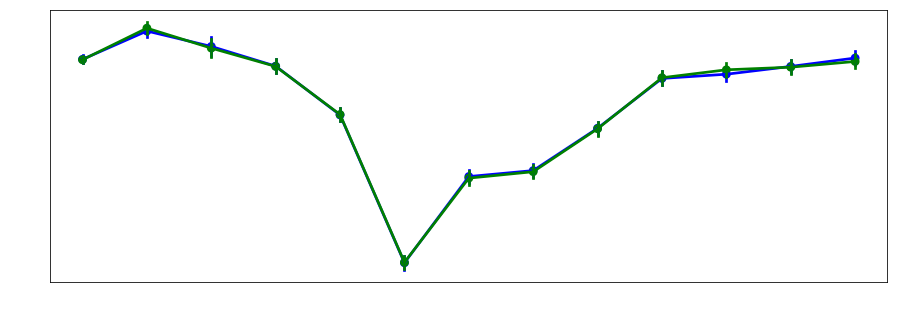

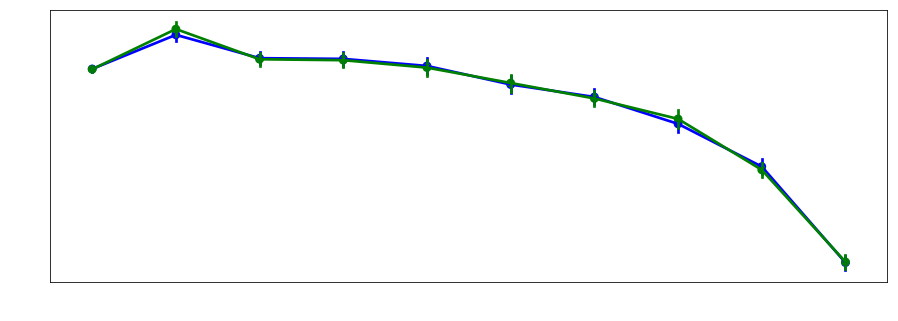

In [11]:
# 猜测：短期内重复出现的title，标签是否有规律
tempDf = df.sort_values(['title','instance_id'])
tempDf['temp'] = tempDf['title'].shift(1)
tempDf['pre_title'] = tempDf['instance_id'].shift(1)
tempDf['pre_title'] = tempDf['instance_id'] - tempDf['pre_title']
tempDf.loc[tempDf.title!=tempDf.temp, 'pre_title'] = -1
tempDf['temp'] = tempDf['title'].shift(-1)
tempDf['next_title'] = tempDf['instance_id'].shift(-1)
tempDf['next_title'] = tempDf['next_title'] - tempDf['instance_id']
tempDf.loc[tempDf.title!=tempDf.temp, 'next_title'] = -1

plt.figure(figsize=(15,5))
temp = pd.qcut(tempDf['pre_title'], 15, duplicates='drop')
sns.pointplot(x=temp, y=tempDf['label'], color='b')
temp = pd.qcut(tempDf['next_title'], 15, duplicates='drop')
sns.pointplot(x=temp, y=tempDf['label'], color='g')

plt.figure(figsize=(15,5))
temp = pd.qcut(tempDf[tempDf.pre_title<50]['pre_title'], 15, duplicates='drop')
sns.pointplot(x=temp, y=tempDf[tempDf.pre_title<50]['label'], color='b')
temp = pd.qcut(tempDf[tempDf.next_title<50]['next_title'], 15, duplicates='drop')
sns.pointplot(x=temp, y=tempDf[tempDf.next_title<50]['label'], color='g')

/home/admin/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/admin/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


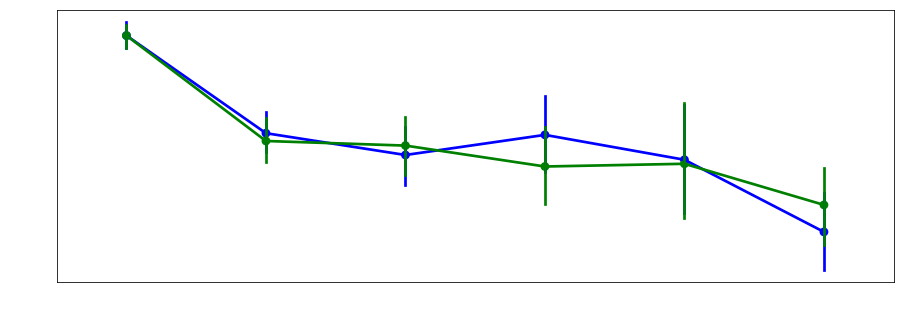

In [12]:
# 猜测：短期内重复出现的prefix，标签是否有规律
tempDf = df.sort_values(['prefix','instance_id'])
tempDf['temp'] = tempDf['prefix'].shift(1)
tempDf['pre_prefix'] = tempDf['instance_id'].shift(1)
tempDf['pre_prefix'] = tempDf['instance_id'] - tempDf['pre_prefix']
tempDf.loc[tempDf.prefix!=tempDf.temp, 'pre_prefix'] = -1
tempDf['temp'] = tempDf['prefix'].shift(-1)
tempDf['next_prefix'] = tempDf['instance_id'].shift(-1)
tempDf['next_prefix'] = tempDf['next_prefix'] - tempDf['instance_id']
tempDf.loc[tempDf.prefix!=tempDf.temp, 'next_prefix'] = -1

plt.figure(figsize=(15,5))
temp = pd.qcut(tempDf[tempDf.pre_prefix<50]['pre_prefix'], 15, duplicates='drop')
sns.pointplot(x=temp, y=tempDf[tempDf.pre_prefix<50]['label'], color='b')
temp = pd.qcut(tempDf[tempDf.next_prefix<50]['next_prefix'], 15, duplicates='drop')
sns.pointplot(x=temp, y=tempDf[tempDf.next_prefix<50]['label'], color='g')

/home/admin/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/admin/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


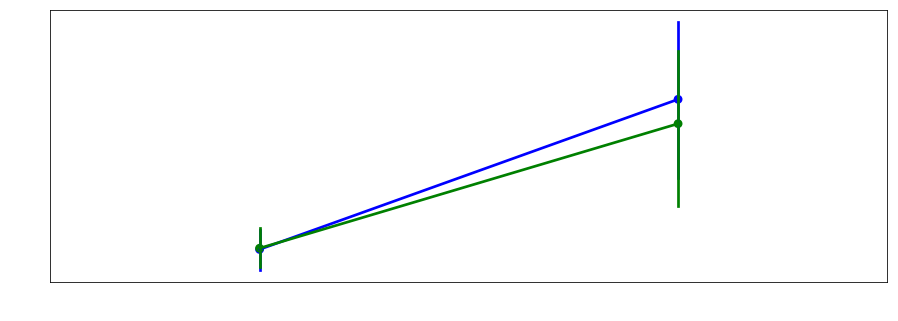

In [13]:
# 验证集是否也有相似的分布？？
tempDf = validDf.sort_values(['title','instance_id'])
tempDf['temp'] = tempDf['title'].shift(1)
tempDf['pre_title'] = tempDf['instance_id'].shift(1)
tempDf['pre_title'] = tempDf['instance_id'] - tempDf['pre_title']
tempDf.loc[tempDf.title!=tempDf.temp, 'pre_title'] = -1
tempDf['temp'] = tempDf['title'].shift(-1)
tempDf['next_title'] = tempDf['instance_id'].shift(-1)
tempDf['next_title'] = tempDf['next_title'] - tempDf['instance_id']
tempDf.loc[tempDf.title!=tempDf.temp, 'next_title'] = -1

plt.figure(figsize=(15,5))
temp = pd.qcut(tempDf[tempDf.pre_title<50]['pre_title'], 15, duplicates='drop')
sns.pointplot(x=temp, y=tempDf[tempDf.pre_title<50]['label'], color='b')
temp = pd.qcut(tempDf[tempDf.next_title<50]['next_title'], 15, duplicates='drop')
sns.pointplot(x=temp, y=tempDf[tempDf.next_title<50]['label'], color='g')

/home/admin/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/admin/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


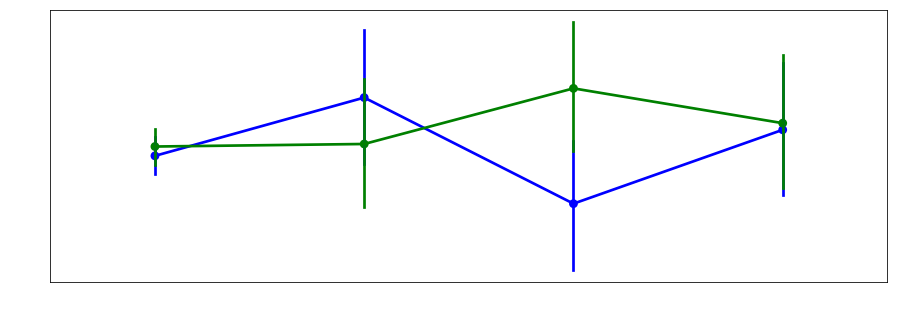

In [14]:
tempDf = validDf.sort_values(['prefix','instance_id'])
tempDf['temp'] = tempDf['prefix'].shift(1)
tempDf['pre_prefix'] = tempDf['instance_id'].shift(1)
tempDf['pre_prefix'] = tempDf['instance_id'] - tempDf['pre_prefix']
tempDf.loc[tempDf.prefix!=tempDf.temp, 'pre_prefix'] = -1
tempDf['temp'] = tempDf['prefix'].shift(-1)
tempDf['next_prefix'] = tempDf['instance_id'].shift(-1)
tempDf['next_prefix'] = tempDf['next_prefix'] - tempDf['instance_id']
tempDf.loc[tempDf.prefix!=tempDf.temp, 'next_prefix'] = -1

plt.figure(figsize=(15,5))
temp = pd.qcut(tempDf[tempDf.pre_prefix<50]['pre_prefix'], 15, duplicates='drop')
sns.pointplot(x=temp, y=tempDf[tempDf.pre_prefix<50]['label'], color='b')
temp = pd.qcut(tempDf[tempDf.next_prefix<50]['next_prefix'], 15, duplicates='drop')
sns.pointplot(x=temp, y=tempDf[tempDf.next_prefix<50]['label'], color='g')

In [15]:
print(tempDf[tempDf.pre_prefix<50].describe())

        instance_id         label  query_predict_num     flag    pre_prefix  \
count  27142.000000  27142.000000       27142.000000  27142.0  27142.000000   
mean   23223.438914      0.381254           9.918171      1.0      3.096271   
std    14739.257253      0.485704           2.743625      0.0     10.193282   
min        0.000000      0.000000           0.000000      1.0     -1.000000   
25%     9725.000000      0.000000          11.000000      1.0     -1.000000   
50%    22913.500000      0.000000          11.000000      1.0     -1.000000   
75%    35698.750000      1.000000          11.000000      1.0     -1.000000   
max    49999.000000      1.000000          11.000000      1.0     49.000000   

        next_prefix  
count  27142.000000  
mean    1488.314789  
std     4151.744708  
min       -1.000000  
25%       -1.000000  
50%       -1.000000  
75%       70.000000  
max    47083.000000  


/home/admin/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/admin/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/admin/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `ar

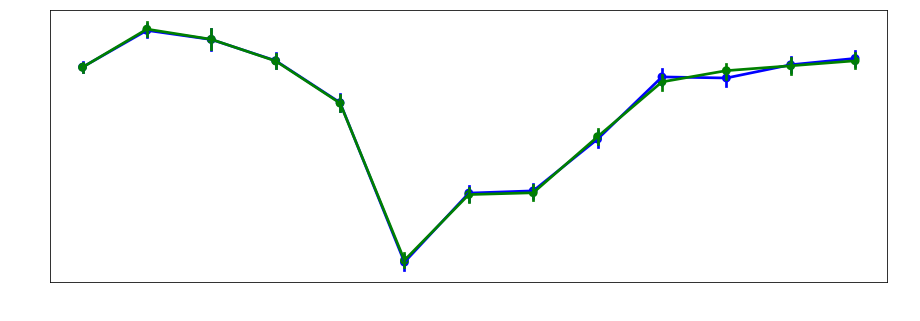

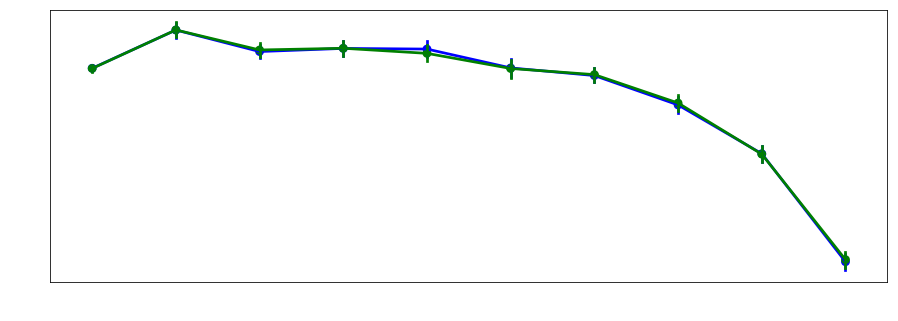

In [4]:
# 有可能是同title不同tag，考虑下title跟tag的拼接会不会更准？？
tempDf = df.sort_values(['title','tag','instance_id'])
tempDf['title_tag'] = tempDf['title'] + tempDf['tag']
tempDf['temp'] = tempDf['title_tag'].shift(1)
tempDf['pre_title_tag'] = tempDf['instance_id'].shift(1)
tempDf['pre_title_tag'] = tempDf['instance_id'] - tempDf['pre_title_tag']
tempDf.loc[tempDf.title_tag!=tempDf.temp, 'pre_title_tag'] = -1
tempDf['temp'] = tempDf['title_tag'].shift(-1)
tempDf['next_title_tag'] = tempDf['instance_id'].shift(-1)
tempDf['next_title_tag'] = tempDf['next_title_tag'] - tempDf['instance_id']
tempDf.loc[tempDf.title_tag!=tempDf.temp, 'next_title_tag'] = -1

plt.figure(figsize=(15,5))
temp = pd.qcut(tempDf['pre_title_tag'], 15, duplicates='drop')
sns.pointplot(x=temp, y=tempDf['label'], color='b')
temp = pd.qcut(tempDf['next_title_tag'], 15, duplicates='drop')
sns.pointplot(x=temp, y=tempDf['label'], color='g')

plt.figure(figsize=(15,5))
temp = pd.qcut(tempDf[tempDf.pre_title_tag<50]['pre_title_tag'], 15, duplicates='drop')
sns.pointplot(x=temp, y=tempDf[tempDf.pre_title_tag<50]['label'], color='b')
temp = pd.qcut(tempDf[tempDf.next_title_tag<50]['next_title_tag'], 15, duplicates='drop')
sns.pointplot(x=temp, y=tempDf[tempDf.next_title_tag<50]['label'], color='g')

## 研究prefix在title中的位置信息

In [4]:
# prefix在title中的位置
df['prefix_title_pos'] = df[['prefix','title']].dropna().apply(lambda x: x.title.lower().find(x.prefix.lower()), axis=1)
df['prefix_isin_title'] = (df['prefix_title_pos']>-1).astype(int)
print(df.describe())

              label  query_predict_num       flag  prefix_title_pos  \
count  2.000000e+06       2.000000e+06  2000000.0      2.000000e+06   
mean   3.729595e-01       1.022344e+01        0.0      4.965080e-01   
std    4.835916e-01       2.408075e+00        0.0      1.974056e+00   
min    0.000000e+00       0.000000e+00        0.0     -1.000000e+00   
25%    0.000000e+00       1.100000e+01        0.0      0.000000e+00   
50%    0.000000e+00       1.100000e+01        0.0      0.000000e+00   
75%    1.000000e+00       1.100000e+01        0.0      0.000000e+00   
max    1.000000e+00       1.100000e+01        0.0      1.120000e+02   

       prefix_isin_title  
count       2.000000e+06  
mean        8.818405e-01  
std         3.227970e-01  
min         0.000000e+00  
25%         1.000000e+00  
50%         1.000000e+00  
75%         1.000000e+00  
max         1.000000e+00  


In [5]:
# prefix跟title的长度
df['prefix_len'] = df['prefix'].dropna().map(lambda x: len(x))
df['title_len'] = df['title'].dropna().map(lambda x: len(x))
print(df.describe())

              label  query_predict_num       flag  prefix_title_pos  \
count  2.000000e+06       2.000000e+06  2000000.0      2.000000e+06   
mean   3.729595e-01       1.022344e+01        0.0      4.965080e-01   
std    4.835916e-01       2.408075e+00        0.0      1.974056e+00   
min    0.000000e+00       0.000000e+00        0.0     -1.000000e+00   
25%    0.000000e+00       1.100000e+01        0.0      0.000000e+00   
50%    0.000000e+00       1.100000e+01        0.0      0.000000e+00   
75%    1.000000e+00       1.100000e+01        0.0      0.000000e+00   
max    1.000000e+00       1.100000e+01        0.0      1.120000e+02   

       prefix_isin_title    prefix_len     title_len  
count       2.000000e+06  2.000000e+06  2.000000e+06  
mean        8.818405e-01  2.897248e+00  6.895180e+00  
std         3.227970e-01  1.371587e+00  5.960457e+00  
min         0.000000e+00  1.000000e+00  1.000000e+00  
25%         1.000000e+00  2.000000e+00  4.000000e+00  
50%         1.000000e+00  3.00

In [10]:
print(df.groupby('prefix_title_pos')['label'].agg([len,'mean']))

                      len      mean
prefix_title_pos                   
-1                 236319  0.155485
 0                1386321  0.434196
 1                  75192  0.267728
 2                 155573  0.329659
 3                  38248  0.277374
 4                  35121  0.317303
 5                  22658  0.215068
 6                  13607  0.239362
 7                  11478  0.180432
 8                   5953  0.191500
 9                   5670  0.178836
 10                  2836  0.167137
 11                  1986  0.135448
 12                  1696  0.144458
 13                   999  0.107107
 14                   834  0.131894
 15                   713  0.115007
 16                   684  0.096491
 17                   727  0.114168
 18                   457  0.113786
 19                   381  0.047244
 20                   236  0.088983
 21                   155  0.148387
 22                   298  0.073826
 23                   195  0.107692
 24                   125  0

1. 从统计来看，小于10的位置信息的点击率呈比较明显的线性规律，应该属于比较强的特征
1. 位置特征的拖尾很长。而由title的长度统计可知，75%的title长度小于等于8，因此大多数数据的位置特征理应不会太大
2. 在做组合分析时，可以考虑按照1w为最低样本量对位置特征进行分箱合并


In [10]:
# 分箱合并
df['prefix_title_pos_bin'] = df['prefix_title_pos'].copy()
df.loc[df.prefix_title_pos_bin.isin([8,9]), 'prefix_title_pos_bin'] = 8
df.loc[df.prefix_title_pos_bin>=10, 'prefix_title_pos_bin'] = 9
print(df.groupby('prefix_title_pos_bin')['label'].agg([len,'mean']))

                          len      mean
prefix_title_pos_bin                   
-1                     236319  0.155485
 0                    1386321  0.434196
 1                      75192  0.267728
 2                     155573  0.329659
 3                      38248  0.277374
 4                      35121  0.317303
 5                      22658  0.215068
 6                      13607  0.239362
 7                      11478  0.180432
 8                      11623  0.185322
 9                      13860  0.123737


In [12]:
# 研究跟其他维度的交叉统计规律
tempDf = df.groupby(['tag','prefix_title_pos_bin'])['label'].agg([len,'mean'])
print(tempDf)

                             len      mean
tag prefix_title_pos_bin                  
健康  -1                       147  0.210884
     0                     79188  0.346833
     1                      5570  0.257630
     2                     11515  0.237690
     3                      5286  0.186909
     4                      3611  0.162559
     5                      2214  0.122855
     6                      1830  0.106011
     7                      1503  0.090486
     8                      1855  0.076011
     9                      1844  0.037419
商品  -1                         5  0.000000
     0                      1909  0.117863
     1                       226  0.039823
     2                       403  0.181141
     3                       575  0.085217
     4                       668  0.064371
     5                       241  0.099585
     6                       191  0.115183
     7                       113  0.141593
     8                       173  0.080925
     9     

**有些明显，有些并没有规律，似乎跟tag相关。感觉对于树模型来说，这组特征的效果需要首先能判定tag**

In [23]:
# prefix在title中的相对位置
df['prefix_title_relative_pos'] = df['prefix_title_pos'] / df['title_len']
df.loc[df.prefix_title_relative_pos<0, 'prefix_title_relative_pos'] = np.nan
print(df.describe())

              label  query_predict_num       flag  prefix_title_pos  \
count  2.000000e+06       2.000000e+06  2000000.0      2.000000e+06   
mean   3.729595e-01       1.022344e+01        0.0      4.965080e-01   
std    4.835916e-01       2.408075e+00        0.0      1.974056e+00   
min    0.000000e+00       0.000000e+00        0.0     -1.000000e+00   
25%    0.000000e+00       1.100000e+01        0.0      0.000000e+00   
50%    0.000000e+00       1.100000e+01        0.0      0.000000e+00   
75%    1.000000e+00       1.100000e+01        0.0      0.000000e+00   
max    1.000000e+00       1.100000e+01        0.0      1.120000e+02   

       prefix_isin_title    prefix_len     title_len  prefix_title_pos_bin  \
count       2.000000e+06  2.000000e+06  2.000000e+06          2.000000e+06   
mean        8.818405e-01  2.897248e+00  6.895180e+00          4.491245e-01   
std         3.227970e-01  1.371587e+00  5.960457e+00          1.568726e+00   
min         0.000000e+00  1.000000e+00  1.000000

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


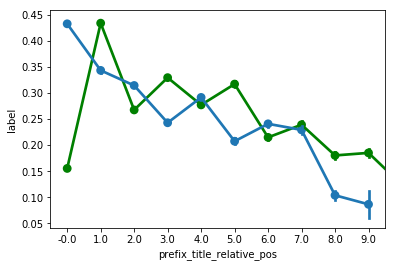

In [24]:
tempDf = df[['prefix_title_relative_pos','prefix_title_pos_bin','prefix_title_pos','label']]
tempDf['prefix_title_relative_pos'] = tempDf['prefix_title_relative_pos'] // 0.1
sns.pointplot(x="prefix_title_pos_bin", y="label", data=tempDf, color='g')
sns.pointplot(x="prefix_title_relative_pos", y="label", data=tempDf)

## 文本字符预处理

In [12]:
str1 = df['prefix'].unique()[:10]
str2 = df['prefix'].sort_values().tail(10).values
print(str1, str2)
print([list(jieba.cut(s.lower())) for s in str1])
print([list(jieba.cut(s.lower())) for s in str2])
print(list(jieba.cut('多久的%2C豆浆')))

['羁' '\x08六合' '红岩金' '高德地图' '12306' '!是什么意思' '0p' '牛奶' '中国志愿' '网易云'] ['😂' '😃' '😃' '😃' '😏' '😒' '😒' '😒 ' '😔' '🙃 ']
[['羁'], ['\x08', '六合'], ['红岩', '金'], ['高德', '地图'], ['12306'], ['!', '是', '什么', '意思'], ['0p'], ['牛奶'], ['中国', '志愿'], ['网易', '云']]
[['😂'], ['😃'], ['😃'], ['😃'], ['😏'], ['😒'], ['😒'], ['😒', ' '], ['😔'], ['🙃', ' ']]
['多久', '的', '%', '2C', '豆浆']


1. 对于逗号编码（%2C），jieba识别不足，可以在分词前进行统一替换
2. 对于表情、16进制符等编码类文本，jieba可以很好的分词，不需要进行额外处理

In [16]:
# 检查是否还有类似%2C的字符编码
titleDf = df[['title']].drop_duplicates()
titleDf['title'] = titleDf['title'].map(lambda x: x.replace('%2C', ','))
titleDf['code'] = titleDf['title'].map(lambda x: re.search('%[\da-zA-Z]+', x))
titleDf['code'] = titleDf['code'].dropna().map(lambda x: x.group())
print(titleDf[titleDf.code.notnull()][['title','code']])

                                                     title        code
10762                                           6%DOKIDOKI   %DOKIDOKI
249040   #include<stdio.h> int main() {int a=5,b=6,c=7,...          %d
630606    某公司向西欧推销箱装货，原报价每箱50美元FOB上海，现客户要求改报CFRC3%Hamburg。    %Hamburg
1022752          int y=2456; printf("y=%3o\n",y); 输出结果是什么？         %3o
1370505                大姨妈占卜，很准的！月经日期代表你一个月将要发生的事，80%MM都准哦         %MM
1563127                                 100%polyester是什么面料  %polyester
1602385                        【耽美高%h】耽美动漫。。高H短片的/要男—爱问知识人          %h
1938767            团中央所收缴团费中的（)返还支持基层。A、60%B、65%C、70%D、80%          %B
